In [1]:
# let imprt some common lib
import os
import sys
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mat73
import torch
# cv2
import cv2
import re
import lpips  # Make sure you have the LPIPS library installed


data_root = r"C:\Users\Alireza\OneDrive - Harvard University\Documents\cosine_preprocess_data"

In [2]:
def get_real_pos_img_unit8(img, center_pos_deg, img_size_deg, screen_size=3, grayness_level=0.5, pixels_per_deg=128):
    """
    Places an image on an imaginary screen with specified parameters.

    Parameters:
    - img: Input image as a NumPy array.
    - center_pos_deg: Tuple or list with 2 elements indicating the center position of the image in degrees.
    - img_size_deg: Size of the image in degrees.
    - screen_size: Size of the screen in degrees. Default is 3.
    - grayness_level: Grayness level of the screen, between 0 and 1. Default is 0.5.
    - pixels_per_deg: Number of pixels per degree. Default is 128.

    Returns:
    - A NumPy array representing the output image with the input image placed on the gray screen.
    """

    # Constants
    screen_size_pixels = int(screen_size * pixels_per_deg)

    # Create a gray background screen
    # make image if the input image! (i.e., 3D)
    if len(img.shape) == 3:
        out_img = np.uint8(255 * grayness_level * np.ones((screen_size_pixels, screen_size_pixels, 3)))
    elif len(img.shape) == 2:
        out_img = np.zeros((screen_size_pixels, screen_size_pixels))
    else:
        raise ValueError("Input image must be either 2D (grayscale) or 3D (RGB).")

    # Calculate the image size in pixels
    img_size_pixels = int(img_size_deg * pixels_per_deg)
    center_pos_deg_rev = [-center_pos_deg[1], center_pos_deg[0]]
    
    # Calculate the top-left corner of the image based on the center position
    center_pos_pixels = np.array(center_pos_deg_rev) * pixels_per_deg + np.array([screen_size_pixels / 2, screen_size_pixels / 2])
    top_left_corner = np.round(center_pos_pixels - img_size_pixels / 2).astype(int)
    
    # Resize the input image to the specified size in pixels
    resized_img = cv2.resize(img, (img_size_pixels, img_size_pixels))

    # Determine the cropping bounds
    crop_row_start, crop_col_start = max(1, -top_left_corner[0] + 1), max(1, -top_left_corner[1] + 1)
    crop_row_end, crop_col_end = min(img_size_pixels, screen_size_pixels - top_left_corner[0]), min(img_size_pixels, screen_size_pixels - top_left_corner[1])

    # Crop the image if it goes outside the screen
    if len(img.shape) == 3:
        cropped_img = resized_img[crop_row_start-1:crop_row_end, crop_col_start-1:crop_col_end, :]
    elif len(img.shape) == 2:
        cropped_img = resized_img[crop_row_start-1:crop_row_end, crop_col_start-1:crop_col_end]

    # Update the top-left corner for placing the cropped image
    top_left_corner = np.maximum(top_left_corner, [1, 1])
    bottom_right_corner = np.minimum(top_left_corner + np.array(cropped_img.shape[:2]) - 1, [screen_size_pixels, screen_size_pixels])

    # Place the cropped/resized image on the gray screen
    if len(img.shape) == 3:
        out_img[top_left_corner[0]-1:bottom_right_corner[0], top_left_corner[1]-1:bottom_right_corner[1], :] = cropped_img
    elif len(img.shape) == 2:
        out_img[top_left_corner[0]-1:bottom_right_corner[0], top_left_corner[1]-1:bottom_right_corner[1]] = cropped_img

    return out_img


import torchvision.transforms.functional as F

def get_real_pos_img_torch(img, center_pos_deg, img_size_deg, screen_size=3, grayness_level=0.5, pixels_per_deg=128):
    """
    Places an image on an imaginary screen with specified parameters, using PyTorch tensors.

    Parameters:
    - img (torch.Tensor): Input image as a PyTorch tensor of shape (C, H, W) or (1, H, W) for grayscale.
    - center_pos_deg (tuple or list): Center position of the image in degrees.
    - img_size_deg (float): Size of the image in degrees.
    - screen_size (float): Size of the screen in degrees. Default is 3.
    - grayness_level (float): Grayness level of the screen, between 0 and 1. Default is 0.5.
    - pixels_per_deg (int): Number of pixels per degree. Default is 128.

    Returns:
    - torch.Tensor: Output image with the input image placed on the gray screen.
    """

    # Constants
    screen_size_pixels = int(screen_size * pixels_per_deg)
    img_size_pixels = int(img_size_deg * pixels_per_deg)

    # Create a gray background screen
    if img.dim() == 3:
        out_img =  grayness_level * torch.ones((3, screen_size_pixels, screen_size_pixels))
    elif img.dim() == 2:
        out_img = grayness_level * torch.ones((1, screen_size_pixels, screen_size_pixels))
        img = img.unsqueeze(0)
    else:
        raise ValueError("Input image tensor must be 2D (1, H, W) for grayscale or 3D (C, H, W) for RGB.")

    center_pos_deg_rev = [-center_pos_deg[1], center_pos_deg[0]]
    
    # Calculate the top-left corner of the image based on the center position
    center_pos_pixels = np.array(center_pos_deg_rev) * pixels_per_deg + np.array([screen_size_pixels / 2, screen_size_pixels / 2])
    top_left_corner = np.round(center_pos_pixels - img_size_pixels / 2).astype(int)
    
    # Resize the input image to the specified size in pixels
    resized_img = F.resize(img, [img_size_pixels, img_size_pixels])

    # Determine the cropping bounds
    crop_row_start, crop_col_start = max(1, -top_left_corner[0] + 1), max(1, -top_left_corner[1] + 1)
    crop_row_end, crop_col_end = min(img_size_pixels, screen_size_pixels - top_left_corner[0]), min(img_size_pixels, screen_size_pixels - top_left_corner[1])

    # Crop the image if it goes outside the screen
    cropped_img = resized_img[:, crop_row_start-1:crop_row_end, crop_col_start-1:crop_col_end]

    # Update the top-left corner for placing the cropped image
    top_left_corner = np.maximum(top_left_corner, [1, 1])
    bottom_right_corner = np.minimum(top_left_corner + np.array(cropped_img.shape[1:]) - 1, [screen_size_pixels, screen_size_pixels])

    # Place the cropped/resized image on the gray screen
    out_img[:, top_left_corner[0]-1:bottom_right_corner[0], top_left_corner[1]-1:bottom_right_corner[1]] = cropped_img

    return out_img.squeeze()




In [3]:
def extract_info_proto_exp(filename):
    # Define the regular expression pattern to match the filename format
    pattern = r'^(.*?)_thread(\d+)_expId(\d+)_chan(\d+)_unit(\d+)\.mat$'
    
    # Use the re.match function to find matches
    match = re.match(pattern, filename)
    
    # Check if the pattern was found within the filename
    if match:
        # Extract the matched groups
        exp_name, ithread, expId, chan, unit = match.groups()
        
        # Convert numerical values to integers
        ithread = int(ithread)
        expId = int(expId)
        chan = int(chan)
        unit = int(unit)
        
        # Return the extracted information as a dictionary
        return {
            'exp_name': exp_name,
            'ithread': ithread,
            'expId': expId,
            'chan': chan,
            'unit': unit
        }
    else:
        # Return None if the filename does not match the expected format
        return None


In [4]:
def apply_mask_to_image_uint8(image, mask):
    """
    Applies a given mask to a given image by expanding the mask to match the image's dimensions and then
    performing an element-wise multiplication.

    Parameters:
    - image: A numpy array representing the image, expected to be in the shape (height, width, channels).
    - mask: A numpy array representing the mask, expected to be in the shape (height, width) with values between 0 and 1.

    Returns:
    - A numpy array of the masked image, with the same shape as the input image.
    """

    # Expand the mask dimensions to match the image's channels
    expanded_mask = np.expand_dims(mask, axis=-1)  # Add a third dimension to the mask
    expanded_mask = np.repeat(expanded_mask, image.shape[2], axis=-1)  # Repeat the mask for each channel

    # Multiply the image with the expanded mask and convert to uint8
    masked_image = (image * expanded_mask).astype('uint8')

    return masked_image

def apply_mask_to_image_torch(image, mask):
    """
    Applies a given mask to a given image using PyTorch. The mask is expanded to match the image's dimensions and then
    an element-wise multiplication is performed.

    Parameters:
    - image (torch.Tensor): A tensor representing the image, expected to be in the shape (C, H, W).
    - mask (torch.Tensor): A tensor representing the mask, expected to be in the shape (H, W) with values between 0 and 1.

    Returns:
    - torch.Tensor: A tensor of the masked image, with the same shape as the input image, without converting to uint8.
    """

    # Ensure mask is a floating point tensor for multiplication
    if mask.dtype != torch.float32:
        mask = mask.to(torch.float32)

    # Expand the mask dimensions to match the image's channels
    expanded_mask = mask.unsqueeze(0)  # Add a new dimension at the beginning to represent channels

    # Repeat the mask for each channel in the image
    expanded_mask = expanded_mask.expand(image.size(0), -1, -1)  # Expand the mask to match the image's channels

    # Multiply the image with the expanded mask
    masked_image = image * expanded_mask

    return masked_image


def apply_mask_to_image_torch(image, mask):
    """
    Applies a given mask to a given image batch using PyTorch. The mask is expanded to match the image's dimensions and then
    an element-wise multiplication is performed.

    Parameters:
    - image (torch.Tensor): A tensor representing the image batch, expected to be in the shape (B, C, H, W).
    - mask (torch.Tensor): A tensor representing the mask batch, expected to be in the shape (B, H, W) with values between 0 and 1.

    Returns:
    - torch.Tensor: A tensor of the masked image batch, with the same shape as the input images.
    """

    # Ensure tensors are in batch form
    if image.dim() == 3:  # If the image tensor is (C, H, W), add the batch dimension
        image = image.unsqueeze(0)
    if mask.dim() == 2:  # If the mask tensor is (H, W), add the batch dimension
        mask = mask.unsqueeze(0)

    # Add the channel dimension to the mask (B, 1, H, W)
    mask = mask.unsqueeze(1)

    # Repeat the mask for each channel in the image
    mask = mask.expand(-1, image.size(1), -1, -1)  # Expand the mask to match the image's channels

    # Multiply the image with the expanded mask
    masked_image = image * mask

    return masked_image

In [5]:
def np_image_to_torch_tensor(np_image):
    """
    Convert a NumPy image array (H, W, C) with dtype=uint8 to a PyTorch tensor (C, H, W) with float values scaled relative to the maximum value in the tensor.

    Parameters:
    np_image (numpy.ndarray): Input image as a NumPy array with shape (H, W, C) and dtype=uint8.

    Returns:
    torch.Tensor: Output image as a PyTorch tensor with shape (C, H, W) and values scaled relative to the maximum value.
    """
    # Ensure input is a NumPy array
    if not isinstance(np_image, np.ndarray):
        raise TypeError("Input must be a NumPy array")

    # Check if the input array has 3 dimensions (H, W, C)
    if np_image.ndim != 3:
        raise ValueError("Input array must have 3 dimensions (H, W, C)")

    # Convert to (C, H, W)
    np_image_transposed = np.transpose(np_image, (2, 0, 1))

    # Convert to a PyTorch tensor
    tensor_image = torch.from_numpy(np_image_transposed).float()

    # Scale relative to the maximum value
    max_value = torch.max(tensor_image)
    if max_value > 0:  # Avoid division by zero
        tensor_image /= max_value

    return tensor_image


In [6]:
def compute_lpips_similarity_unit8(img1_np, img2_np, net_type='alex'): # TODO: make it bach freindly
    """
    Compute the LPIPS similarity between two images.

    Parameters:
    img1_np (numpy.ndarray): First input image as a NumPy array with shape (H, W, C) and dtype=uint8.
    img2_np (numpy.ndarray): Second input image as a NumPy array with shape (H, W, C) and dtype=uint8.
    net_type (str): Type of network to use for LPIPS computation ('alex', 'vgg', etc.).

    Returns:
    float: LPIPS similarity value.
    """
    # Initialize the LPIPS model
    #lpips_model = lpips.LPIPS(net=net_type).cuda() if torch.cuda.is_available() else lpips.LPIPS(net=net_type)
    lpips_model = lpips.LPIPS(net=net_type, spatial=True)

    
    # Convert NumPy arrays to PyTorch tensors and add batch dimension
    img1_tensor = np_image_to_torch_tensor(img1_np).unsqueeze(0)  # Convert and add batch dimension
    img2_tensor = np_image_to_torch_tensor(img2_np).unsqueeze(0)  # Convert and add batch dimension

    # Compute LPIPS similarity
    with torch.no_grad():
        similarity_map = lpips_model.forward(img1_tensor, img2_tensor)
    
    # Convert similarity map to image for visualization
    similarity_map_img = similarity_map.squeeze().cpu().numpy()  # Remove batch dimension and transfer to CPU
    similarity_map_img = (similarity_map_img - similarity_map_img.min()) / (similarity_map_img.max() - similarity_map_img.min())  # Normalize to 0-1 range

    return similarity_map, similarity_map_img



def compute_lpips_similarity(img1, img2_batch, net_type='alex'):
    """
    Compute the LPIPS similarity between one image and a batch of images.

    Parameters:
    - img1 (torch.Tensor): First input image as a torch tensor with shape (C, H, W).
    - img2_batch (torch.Tensor): Batch of second input images as a torch tensor with shape (B, C, H, W).
    - net_type (str): Type of network to use for LPIPS computation ('alex', 'vgg', etc.).

    Returns:
    - torch.Tensor: LPIPS similarity values for each image in the batch.
    """

    # Initialize the LPIPS model with the specified network type
    lpips_model = lpips.LPIPS(net=net_type, spatial=True)  # spatial=True returns a spatial map of similarities

    # Add an extra batch dimension to img1 to match the (N, C, H, W) format
    img1_batch = img1.unsqueeze(0)

    # Move the LPIPS model to the same device as the input tensors
    if torch.cuda.is_available():
        lpips_model = lpips_model.to('cpu')
        img1 = img1.to('cpu')
        img2_batch = img2_batch.to('cpu')
    else:
        device = img1_batch.device  # Get the device from the input tensor
        img2_batch = img2_batch.to(device)  # Move the batch of images to the correct device
        lpips_model = lpips_model.to(device)  # Move LPIPS model to the correct device

    # Compute LPIPS similarity
    similarity_map = lpips_model.forward(img1_batch, img2_batch)

    # Convert similarity map to image for visualization
    # Normalize the similarity map to be between 0 and 1 for visualization
    similarity_map_norm = (similarity_map - similarity_map.min()) / (similarity_map.max() - similarity_map.min())
    #similarity_map_img = similarity_map_norm.squeeze().cpu().detach()  # Remove batch dimension and move to CPU

    return similarity_map, similarity_map_norm



In [7]:
def uint8_image_to_pytorch(image):
    """
    Convert a uint8 image (numpy array) to a PyTorch tensor.

    Parameters:
        image (numpy.ndarray): An image array with shape (H, W, C) and uint8 type.

    Returns:
        torch.Tensor: A PyTorch tensor of the image with shape (C, H, W) and float type.
    """
    # Convert the image to float and scale to [0, 1]
    image_float = image.astype(np.float32) / 255.0
    
    # Rearrange the dimensions from HWC to CHW
    image_transposed = np.transpose(image_float, (2, 0, 1))
    
    # Convert the NumPy array to a PyTorch tensor
    image_tensor = torch.from_numpy(image_transposed)
    
    return image_tensor

In [8]:
def process_gen_image_strings(cell_array):
    # Initialize arrays
    n = len(cell_array)
    is_gen = np.full(n, False)
    block_ids = np.full(n, np.nan)
    thread_ids = np.full(n, np.nan)
    gen_ids = np.full(n, np.nan)
    counters = np.full(n, np.nan)
    is_nat = np.full(n, False)
    nat_gen = np.full(n, np.nan)

    # Define the regular expression patterns
    gen_pattern = r'^block(\d{3})_thread(\d{3})_gen_gen(\d{3})_(\d{6})$'
    nat_pattern = r'_nat'
    last_gen_id = 0

    for i, string in enumerate(cell_array):
        tokens_gen = re.findall(gen_pattern, string)
        tokens_nat = nat_pattern in string

        # Check if the string matches the pattern
        if tokens_gen:
            is_gen[i] = True
            tokens_gen = tokens_gen[0]

            # Extract and convert each part of the string
            block_ids[i] = int(tokens_gen[0])
            thread_ids[i] = int(tokens_gen[1])
            gen_ids[i] = int(tokens_gen[2])
            counters[i] = int(tokens_gen[3])
            last_gen_id = gen_ids[i]

        # Check if the string matches the pattern for natural image
        if tokens_nat:
            is_nat[i] = True
            nat_gen[i] = last_gen_id

    return is_gen, block_ids, thread_ids, gen_ids, counters, is_nat, nat_gen


In [9]:
def analyze_by_gen(values, gen_ids):
    """
    Analyze by Generation - Calculates and sorts mean, standard deviation, and SEM for each generation
    for 2D input values, performing operations along the second dimension.

    Parameters:
    values (np.ndarray): 2D array of values. If 1D, it will be reshaped.
    gen_ids (np.ndarray): Array of corresponding generation IDs.

    Returns:
    gen_means (np.ndarray): Mean of values for each generation, sorted by generation ID.
    gen_stds (np.ndarray): Standard deviation of values for each generation, sorted by generation ID.
    gen_sems (np.ndarray): Standard error of the mean for each generation, sorted by generation ID.
    unique_gens (np.ndarray): Sorted list of unique generation IDs.
    """
    # Ensure values are 2D, reshaping if necessary
    if values.ndim == 1:
        values = values.reshape(1, -1) #TODO: check if it is correct

    # Find unique generation IDs and sort them
    unique_gens = np.unique(gen_ids)
    n_gens = len(unique_gens)

    # Initialize output arrays
    gen_means = np.zeros((values.shape[0], n_gens))
    gen_stds = np.zeros((values.shape[0], n_gens))
    gen_sems = np.zeros((values.shape[0], n_gens))

    # Calculate statistics for each generation
    for i, gen in enumerate(unique_gens):
        gen_mask = gen_ids == gen
        gen_values = values[:, gen_mask]

        gen_means[:, i] = np.nanmean(gen_values, axis=1)
        gen_stds[:, i] = np.nanstd(gen_values, axis=1)
        n_values = np.sum(gen_mask)  # Number of values for this generation
        gen_sems[:, i] = gen_stds[:, i] / np.sqrt(n_values)

    return gen_means, gen_stds, gen_sems, unique_gens


In [10]:
def make_binary_mask_np(mask, x=1.25):
    """
    Converts a mask with continuous values between 0 and 1 into a binary mask.
    The binary threshold is set to mean + x * standard deviation of the mask values.
    
    Parameters:
    mask (np.ndarray): 2D array of continuous values between 0 and 1.
    x (float): Multiplier for the standard deviation to define the threshold.
    
    Returns:
    binary_mask (np.ndarray): 2D binary mask with the same shape as the input mask.
    """
    # Calculate mean and standard deviation of the mask values
    mean_val = np.mean(mask)
    std_val = np.std(mask)
    
    # Define the threshold as mean + x * standard deviation
    threshold = mean_val + x * std_val
    
    # Generate binary mask: 1 for values greater than the threshold, 0 otherwise
    binary_mask = np.where(mask > threshold, 1, 0)
    
    return binary_mask

def make_binary_mask_torch(mask, x=1.25):
    """
    Converts a mask with continuous values between 0 and 1 into a binary mask using PyTorch.
    The binary threshold is set to mean + x * standard deviation of the mask values.
    
    Parameters:
    mask (torch.Tensor): 2D tensor of continuous values between 0 and 1.
    x (float): Multiplier for the standard deviation to define the threshold.
    
    Returns:
    binary_mask (torch.Tensor): 2D binary mask with the same shape as the input mask.
    """
    # Ensure mask is a float tensor for mean and std calculations
    mask_float = mask.float()
    
    # Calculate mean and standard deviation of the mask values
    mean_val = torch.mean(mask_float)
    std_val = torch.std(mask_float)
    
    # Define the threshold as mean + x * standard deviation
    threshold = mean_val + x * std_val
    
    # Generate binary mask: 1 for values greater than the threshold, 0 otherwise
    binary_mask = (mask_float > threshold).float()  # Convert to float for 0.0 and 1.0 values
    
    return binary_mask

In [11]:
def average_nonzero(tensor, dims):
    """
    Calculates the average of all non-zero values in the specified dimensions of a PyTorch tensor.
    
    Parameters:
    tensor (torch.Tensor): The input tensor.
    dims (tuple): The dimensions along which to calculate the average of non-zero values.
    
    Returns:
    avg_nonzero (torch.Tensor): The average of non-zero values along the specified dimensions.
    """
    # Create a mask of non-zero values
    nonzero_mask = tensor != 0

    # Use the mask to select non-zero values
    nonzero_values = tensor * nonzero_mask
    
    # Calculate the sum and the count of non-zero values along the specified dimensions
    nonzero_sum = torch.sum(nonzero_values, dim=dims, keepdim=True)
    nonzero_count = torch.sum(nonzero_mask, dim=dims, keepdim=True)

    # Avoid division by zero by using where to only calculate average where count > 0
    avg_nonzero = torch.where(nonzero_count > 0, nonzero_sum / nonzero_count, torch.tensor(0.0, device=tensor.device))
    
    return avg_nonzero.squeeze() # Remove the squeezed dimensions if you want to


In [12]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import f

def get_lreg_sklearn(resp, gen_id, abs_flag):
    """
    Applies optional absolute value, z-scores responses, removes NaNs, and performs linear regression on each row (unit),
    initializing output arrays with np.nan.
    """

    # Z-score responses for each unit along columns
    resp_zs = (resp - np.nanmean(resp, axis=1, keepdims=True)) / np.nanstd(resp, axis=1, keepdims=True)

    # Apply absolute value if flagged
    if abs_flag == 1:
        resp_zs = np.abs(resp_zs)

    # Initialize output arrays with np.nan
    n_units = resp_zs.shape[0]
    slope_vec = np.full(n_units, np.nan)
    intercept_vec = np.full(n_units, np.nan)
    pValue_vec = np.full(n_units, np.nan)
    r2_vec = np.full(n_units, np.nan)  # Initialize R² array

   # Instantiate LinearRegression object outside the loop
    regr = LinearRegression()

    for ui in range(n_units):
        # Identify rows without NaNs
        valid_indices = ~np.isnan(resp_zs[ui, :])
        valid_resp = resp_zs[ui, valid_indices]
        valid_gen_id = gen_id[valid_indices].reshape(-1, 1)

        if valid_resp.size > 0:  # Proceed if there are non-NaN values
            # Fit linear regression model
            regr.fit(valid_gen_id, valid_resp)

            # Get coefficients
            intercept_vec[ui] = regr.intercept_
            slope_vec[ui] = regr.coef_[0]

            # Calculate R² value
            r2 = regr.score(valid_gen_id, valid_resp)
            r2_vec[ui] = r2

            # Calculate F-statistic and corresponding p-value
            n = len(valid_resp)
            p = 1  # Number of predictors, not counting the intercept
            dfn = p  # Degrees of freedom for the numerator
            dfd = n - p - 1  # Degrees of freedom for the denominator
            F = (r2 / dfn) / ((1 - r2) / dfd)
            pValue_vec[ui] = 1 - f.cdf(F, dfn, dfd)

    return slope_vec, intercept_vec, pValue_vec, r2_vec


In [13]:
# let's load the reconstruction exp data
recon_exp_path = os.path.join(data_root, "recon_data")
proto_exp_path = os.path.join(data_root, "unit_proto")
scram_exp_path = os.path.join(data_root, "unit_scram")
recon_exp_files = os.listdir(recon_exp_path)
proto_exp_files = os.listdir(proto_exp_path)
scram_exp_files = os.listdir(scram_exp_path)


In [17]:
# let load the proto and corosponding mask if it posible plus the size 
# let save the proto and mask and other info in a pd
proto_and_mask_info = pd.DataFrame(columns=['exp_name', 'exp_id', 'proto_img',
                                            'proto_mask_exp', 'proto_mask_lin', 'proto_size',
                                            'proto_pos', 'chan_id', 'unit_id'])
c = 0
iamge_size = 256
for proto_exp_id in range(len(proto_exp_files)):
    # use the extract_info function to extract the information from the filename
    proto_file = [f for f in proto_exp_files if f.count(f"expId{proto_exp_id+1:03d}")][0]
    proto_exp_data = mat73.loadmat(os.path.join(proto_exp_path, proto_file))
    proto_exp_info = extract_info_proto_exp(proto_file)
    exp_name_common = '-'.join(proto_exp_info['exp_name'].split('-')[0:2])
    chan_id = proto_exp_info['chan']
    unit_id = proto_exp_info['unit']


    # the scram exp data file name is formated like this [exp_name]_exp_idXXX_chanXX_unitX.mat for example like Caos-30112023-008_expId022_chan71_unit2
    # let's load the coresponded scram exp data which should be [exp_name_common]-*_chan[chan_id]_unit[unit_id].mat
    scram_exp_file = [f for f in scram_exp_files if (f.count(f"chan{chan_id:02d}") and f.count(f"unit{unit_id}") and f.count(exp_name_common))]
    # continue if the file is not found
    if (len(scram_exp_file) == 0) or (proto_exp_data['p_evol'] > .01):
        continue
    scram_exp_file = scram_exp_file[0]
    scram_exp_info = mat73.loadmat(os.path.join(scram_exp_path, scram_exp_file))
    proto_size = scram_exp_info['img_size']
    proto_pos = scram_exp_info['img_pos']

    proto_img = proto_exp_data['top_mean_img_selected']
    proto_mask_exp = scram_exp_info['overlapped_mask_exp']
    proto_mask_lin = scram_exp_info['overlapped_mask_lin']
    # if mask is not the size of image_size then resize it
    if proto_mask_exp.shape[0] != iamge_size:
        proto_mask_exp = cv2.resize(proto_mask_exp, (iamge_size, iamge_size))
    if proto_mask_lin.shape[0] != iamge_size:
        proto_mask_lin = cv2.resize(proto_mask_lin, (iamge_size, iamge_size))
    # if the proto_img is not the size of image_size then resize it
    if proto_img.shape[0] != iamge_size:
        proto_img = cv2.resize(proto_img, (iamge_size, iamge_size))
    # iloc with c
    proto_and_mask_info.loc[c] = [exp_name_common, proto_exp_id, proto_img, proto_mask_exp, proto_mask_lin, proto_size, proto_pos, chan_id, unit_id]
    c += 1
proto_and_mask_info['proto_img_torch'] = proto_and_mask_info['proto_img'].apply(uint8_image_to_pytorch)

In [15]:
# the conver and save the proto_img from uint8 to torch and save them add in a tensor
"""proto_and_mask_info['proto_img_torch'] = proto_and_mask_info['proto_img'].apply(uint8_image_to_pytorch)


porto_img_tensors = [torch.tensor(img, dtype=torch.float32) for img in proto_and_mask_info['proto_img_torch'].values]
# Now you can stack these tensors
porto_img_tensor = torch.stack(porto_img_tensors)

# do the same for the mask
proto_mask_tensors = [torch.tensor(mask, dtype=torch.float32) for mask in proto_and_mask_info['proto_mask'].values]
# Now you can stack these tensors
proto_mask_tensor = torch.stack(proto_mask_tensors)"""

"proto_and_mask_info['proto_img_torch'] = proto_and_mask_info['proto_img'].apply(uint8_image_to_pytorch)\n\n\nporto_img_tensors = [torch.tensor(img, dtype=torch.float32) for img in proto_and_mask_info['proto_img_torch'].values]\n# Now you can stack these tensors\nporto_img_tensor = torch.stack(porto_img_tensors)\n\n# do the same for the mask\nproto_mask_tensors = [torch.tensor(mask, dtype=torch.float32) for mask in proto_and_mask_info['proto_mask'].values]\n# Now you can stack these tensors\nproto_mask_tensor = torch.stack(proto_mask_tensors)"

In [18]:
recon_exp_id = 18

# let's load the file
exp_file = [f for f in recon_exp_files if f.endswith(f"expId{recon_exp_id:03d}.mat")][0]
# load the file
recon_exp_data = mat73.loadmat(os.path.join(recon_exp_path, exp_file))
iThread = 0
target_img_uint8 = recon_exp_data['target_imgs_cell'][iThread]
recon_img_uint8 = recon_exp_data['recon_img_cell'][iThread]
init_img_uint8 = recon_exp_data['init_img_cell'][iThread]
init_img = uint8_image_to_pytorch(init_img_uint8)
target_img = uint8_image_to_pytorch(target_img_uint8)
recon_img = uint8_image_to_pytorch(recon_img_uint8)
img_size = recon_exp_data['img_size'][iThread]
img_poss = recon_exp_data['img_poss'][iThread]
exp_name = recon_exp_data['spike_fn']
exp_id = recon_exp_data['exp_i']
# let's get the real pos for the proto image and the mask based on the img_poss and img_size and save them all in a list
# we have all proto_img_torch and proto_mask_tensor so let do it    
real_pos_proto_img_list = [get_real_pos_img_torch(proto_and_mask_info['proto_img_torch'].iloc[i], proto_and_mask_info['proto_pos'].iloc[i], 
                                             proto_and_mask_info['proto_size'].iloc[i], screen_size=img_size, grayness_level=0, pixels_per_deg=128) for i in range(len(proto_and_mask_info))]
real_pos_mask_list = [get_real_pos_img_torch(torch.from_numpy(proto_and_mask_info['proto_mask_lin'].iloc[i]), proto_and_mask_info['proto_pos'].iloc[i],
                                       proto_and_mask_info['proto_size'].iloc[i], screen_size=img_size, grayness_level=0, pixels_per_deg=128) for i in range(len(proto_and_mask_info))]
real_pos_bin_mask_list = [make_binary_mask_torch(mask) for mask in real_pos_mask_list]
proto_chan_id = [proto_and_mask_info['chan_id'].iloc[i] for i in range(len(proto_and_mask_info))]
proto_unit_id = [proto_and_mask_info['unit_id'].iloc[i] for i in range(len(proto_and_mask_info))]
# let's convert the list to tensor
real_pos_proto_img_tensor = torch.stack(real_pos_proto_img_list)
real_pos_mask_tensor = torch.stack(real_pos_mask_list)
real_pos_bin_mask_tensor = torch.stack(real_pos_bin_mask_list)


# let compute the lpips similarity between the target_img and the proto_img
similarity_map_target, similarity_map_norm_target = compute_lpips_similarity(target_img, real_pos_proto_img_tensor, net_type='alex')

# apply the mask to the similarity_map_img
similarity_map_masked_target = apply_mask_to_image_torch(similarity_map_target, real_pos_bin_mask_tensor)

# let caculate the mean of the similarity_map_masked for each image
#similarity_map_masked_mean_target = similarity_map_target.mean(dim=[1, 2, 3])
similarity_map_masked_mean_target = average_nonzero(similarity_map_target, dims=[1, 2, 3])

# let's do the same for the recon_img
similarity_map_recon, similarity_map_norm_recon = compute_lpips_similarity(recon_img, real_pos_proto_img_tensor, net_type='alex')
similarity_map_masked_recon = apply_mask_to_image_torch(similarity_map_recon, real_pos_bin_mask_tensor)
#similarity_map_masked_mean_recon = similarity_map_recon.mean(dim=[1, 2, 3])
similarity_map_masked_mean_recon = average_nonzero(similarity_map_recon, dims=[1, 2, 3])

# let's do the same for the init_img
similarity_map_init, similarity_map_norm_init = compute_lpips_similarity(init_img, real_pos_proto_img_tensor, net_type='alex')
similarity_map_masked_init = apply_mask_to_image_torch(similarity_map_init, real_pos_bin_mask_tensor)
#similarity_map_masked_mean_init = similarity_map_init.mean(dim=[1, 2, 3])
similarity_map_masked_mean_init = average_nonzero(similarity_map_init, dims=[1, 2, 3])





c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alir

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [on]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [on]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [on]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth


In [ ]:
# let aplay the binary mask to the proto_img print the result

for i in range(len(real_pos_proto_img_tensor)):
    fig, ax = plt.subplots(1, 4, figsize=(10, 5))
    ax[0].imshow(real_pos_proto_img_tensor[i].permute(1, 2, 0))
    ax[0].set_title(f"proto_img: {proto_chan_id[i]}-{proto_unit_id[i]}")
    ax[1].imshow(real_pos_mask_tensor[i].squeeze())
    ax[1].set_title(f"proto_mask: {proto_chan_id[i]}-{proto_unit_id[i]}")
    ax[2].imshow(real_pos_bin_mask_list[i].squeeze())
    ax[2].set_title(f"proto_bin_mask: {proto_chan_id[i]}-{proto_unit_id[i]}")
    ax[3].imshow(apply_mask_to_image_torch(real_pos_proto_img_tensor[i], real_pos_bin_mask_list[i]).squeeze().permute(1, 2, 0))
    ax[3].set_title(f"proto_img_masked: {proto_chan_id[i]}-{proto_unit_id[i]}")
    plt.show()

In [ ]:
# leat's plot the similarity_map_masked_mean_target and similarity_map_masked_mean_recon. these  are tensor so we need to convert them to numpy
similarity_map_masked_mean_target_np = similarity_map_masked_mean_target.detach().numpy()
similarity_map_masked_mean_recon_np = similarity_map_masked_mean_recon.detach().numpy()
similarity_map_masked_mean_init_np = similarity_map_masked_mean_init.detach().numpy()

# let's plot the similarity_map_masked_mean_target and similarity_map_masked_mean_recon and similarity_map_masked_mean_init
fig, ax = plt.subplots(2, 3, figsize=(20, 15))
ax[0, 0].scatter(similarity_map_masked_mean_target_np, similarity_map_masked_mean_recon_np)
ax[0, 0].set_title('target vs recon')
ax[0, 0].set_xlabel('target')
ax[0, 0].set_ylabel('recon')
ax[0, 1].scatter(similarity_map_masked_mean_target_np, similarity_map_masked_mean_init_np)
ax[0, 1].set_title('target vs init')
ax[0, 1].set_xlabel('target')
ax[0, 1].set_ylabel('init')
ax[0, 2].scatter(similarity_map_masked_mean_recon_np, similarity_map_masked_mean_init_np)
ax[0, 2].set_title('recon vs init')
ax[0, 2].set_xlabel('recon')
ax[0, 2].set_ylabel('init')
   
fig, ax = plt.subplots(figsize=(5, 5))
ax.scatter(proto_chan_id, similarity_map_masked_mean_recon_np - similarity_map_masked_mean_init_np)


In [19]:
# let print all te key() in recon_exp_data
for key in recon_exp_data.keys():
    print(key)

all_img_name
array_inc
bk_resp
chan_ids
evoke_resp
exp_i
gan_name
img_poss
img_size
init_img_cell
masks_cell
num_of_thread
pop_mean_call
pop_std_cell
recon_img_cell
resp_trial_col_cell
sampling_mods
score_mods
spike_fn
stimuli_path
target_idx
target_img_path_cell
target_imgs_cell
target_name
target_resps_cell
unit_ids


In [31]:
num_of_last_gen_to_agrage = 2
bk_resp = recon_exp_data['bk_resp']
evoke_resp = recon_exp_data['evoke_resp']
flat_mask = recon_exp_data['masks_cell'][iThread]
unit_id = recon_exp_data['unit_ids']
chan_id = recon_exp_data['chan_ids']
sub_resp = evoke_resp - bk_resp
all_image_names = recon_exp_data['all_img_name']
all_image_names = [all_image_names[i][0] for i in range(len(all_image_names))]
is_gen, block_ids, thread_ids, gen_ids, counters, is_nat, nat_gen = \
            process_gen_image_strings(all_image_names)
thread_mask = is_gen & (thread_ids == iThread)
this_tread_sub_resp = sub_resp[:, thread_mask]
this_tread_gen_ids = gen_ids[thread_mask]
gen_resp_means, gen_stds, gen_sems, unique_gens = analyze_by_gen(sub_resp[:, thread_mask], gen_ids[thread_mask])
target_resp = recon_exp_data['target_resps_cell'][iThread]
delta_resp = this_tread_sub_resp - target_resp[:, None]
delta_resp_each_gen = gen_resp_means - target_resp[:, None]

delta_resp_masked = delta_resp[flat_mask, :]
delta_resp_each_gen_masked = delta_resp_each_gen[flat_mask, :]
slope_vec_masked, intercept_vec_masked, pValue_vec_masked, r2_vec_masked = get_lreg_sklearn(delta_resp_masked, this_tread_gen_ids, 1)

first_gen_delta_resp = delta_resp_each_gen_masked[:, 0]
# let agrage three penunltimate gen (-4, -3, -2)
last_gen_delta_resp = delta_resp_each_gen_masked[:, -num_of_last_gen_to_agrage-1:-1].mean(axis=1)  
unit_id_masked = unit_id[flat_mask]
chan_id_masked = chan_id[flat_mask]
# let have df with this columns ['exp_name', 'exp_id', 'unit_id_masked', 'chan_id_masked', 'delta_resp_each_gen_masked', 'slope_vec_masked' 'intercept_vec_masked', 'pValue_vec_masked', 'r2_vec_masked']

delta_resp_each_gen_masked_df = pd.DataFrame(columns=['exp_name', 'exp_id', 'unit_id_masked', 'chan_id_masked', 'delta_resp_first_gen_masked', 'delta_resp_last_gen_masked',
                                                        'delta_lpips_similarity_mean_target', 'delta_lpips_similarity_mean_recon'])
delta_resp_each_gen_masked_df['exp_name'] = [exp_name]*len(unit_id_masked)
delta_resp_each_gen_masked_df['exp_id'] = [recon_exp_id]*len(unit_id_masked)
delta_resp_each_gen_masked_df['unit_id_masked'] = unit_id_masked
delta_resp_each_gen_masked_df['chan_id_masked'] = chan_id_masked
delta_resp_each_gen_masked_df['delta_resp_first_gen_masked'] = first_gen_delta_resp
delta_resp_each_gen_masked_df['delta_resp_last_gen_masked'] = last_gen_delta_resp
delta_resp_each_gen_masked_df['slope_vec_masked'] = slope_vec_masked
delta_resp_each_gen_masked_df['intercept_vec_masked'] = intercept_vec_masked
delta_resp_each_gen_masked_df['pValue_vec_masked'] = pValue_vec_masked
delta_resp_each_gen_masked_df['r2_vec_masked'] = r2_vec_masked

# let add columns for the lpips_similarity_mean for the target_img and the recon_img, in the coresponed rows based on the unit_id_masked and chan_id_masked and proto_chan_id and proto_unit_id if they are the same otherwise np.nan
delta_resp_each_gen_masked_df['lpips_similarity_mean_target'] = [np.nan]*len(unit_id_masked)
delta_resp_each_gen_masked_df['lpips_similarity_mean_recon'] = [np.nan]*len(unit_id_masked)
delta_resp_each_gen_masked_df['lpips_similarity_mean_init'] = [np.nan]*len(unit_id_masked)
for i in range(len(unit_id_masked)):
    # let find the index of the proto_chan_id and proto_unit_id
    index = (proto_chan_id == chan_id_masked[i]) & (proto_unit_id == unit_id_masked[i])
    if np.sum(index) > 0:
        # if there is more than one index then take the first one
        index = np.where(index)[0][0]
        delta_resp_each_gen_masked_df['lpips_similarity_mean_target'].iloc[i] = similarity_map_masked_mean_target[index].item()
        delta_resp_each_gen_masked_df['lpips_similarity_mean_recon'].iloc[i] = similarity_map_masked_mean_recon[index].item()
        delta_resp_each_gen_masked_df['lpips_similarity_mean_init'].iloc[i] = similarity_map_masked_mean_init[index].item()

C:\Users\Alireza\AppData\Local\Temp\ipykernel_4876\2420162553.py:13: RuntimeWarning: Mean of empty slice
  resp_zs = (resp - np.nanmean(resp, axis=1, keepdims=True)) / np.nanstd(resp, axis=1, keepdims=True)
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\numpy\lib\nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\Alireza\AppData\Local\Temp\ipykernel_4876\2715521677.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  delta_resp_each_gen_masked_df['lpips_similarity_mean_target'].iloc[i] = similarity_map_masked_mean_target[index].item()
C:\Users\Alireza\AppData\Local\Temp\ipykernel_4876\2715521677.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame


C:\Users\Alireza\AppData\Local\Temp\ipykernel_4876\64214563.py:4: RuntimeWarning: Mean of empty slice
  resp_zs = (resp - np.nanmean(resp, axis=1, keepdims=True)) / np.nanstd(resp, axis=1, keepdims=True)
C:\Users\Alireza\AppData\Local\Temp\ipykernel_4876\3548898276.py:34: RuntimeWarning: Mean of empty slice
  gen_means[:, i] = np.nanmean(gen_values, axis=1)


Text(0, 0.5, 'delta resp z-score')

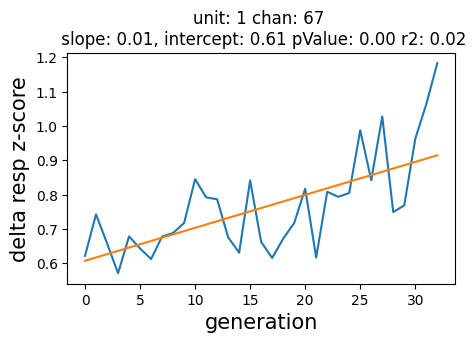

In [62]:
# let for example unit in delta_resp_masked plot it pont and the slope and the intercept (slope_vec_masked, intercept_vec_masked,) you can use also gen_delta_resp_masked
# let plot the delta_resp_masked and the slope and the intercept
resp = delta_resp_masked
resp_zs = (resp - np.nanmean(resp, axis=1, keepdims=True)) / np.nanstd(resp, axis=1, keepdims=True)
resp_zs = np.abs(resp_zs)
gen_delta_means, gen_delta_stds, gen_sems, unique_gens = analyze_by_gen(resp_zs, gen_ids[thread_mask])

sorted_slope_vec_masked_arg = np.argsort((slope_vec_masked))[::-1]
ui = sorted_slope_vec_masked_arg[2]

fig, ax = plt.subplots(figsize=(5, 3))
ax.plot(unique_gens, gen_delta_means[ui, :])
# plot the slope and the intercept
slope = slope_vec_masked[ui]
intercept = intercept_vec_masked[ui]
ax.plot(unique_gens, slope*unique_gens + intercept)
# add the title pvalue and r2 
pValue = pValue_vec_masked[ui]
r2 = r2_vec_masked[ui]
ax.set_title(f"unit: {int(unit_id_masked[ui])} chan: {int(chan_id_masked[ui])} \n slope: {slope:.2f}, intercept: {intercept:.2f} pValue: {pValue:.2f} r2: {r2:.2f}")
ax.set_xlabel('generation', fontsize=15)
ax.set_ylabel('delta resp z-score', fontsize=15)

In [53]:
# let sort slope_vec_masked descending and get arg 
sorted_slope_vec_masked_arg = np.argsort(np.abs(slope_vec_masked))[::-1]
sorted_slope_vec_masked_arg


array([ 3,  6, 49, 36, 41, 48, 60,  4, 19, 16, 21, 40, 10,  8, 66, 42, 56,
       45, 34, 63, 18, 47, 58, 57, 64,  1, 12,  0, 37, 26, 20, 52, 17, 11,
        9, 43, 31, 29, 61, 65, 35, 59, 39, 62, 33, 53, 23, 13,  5, 15, 27,
       22, 44, 38,  2, 46, 25, 28, 30, 51, 50, 24, 32,  7, 55, 14, 54],
      dtype=int64)

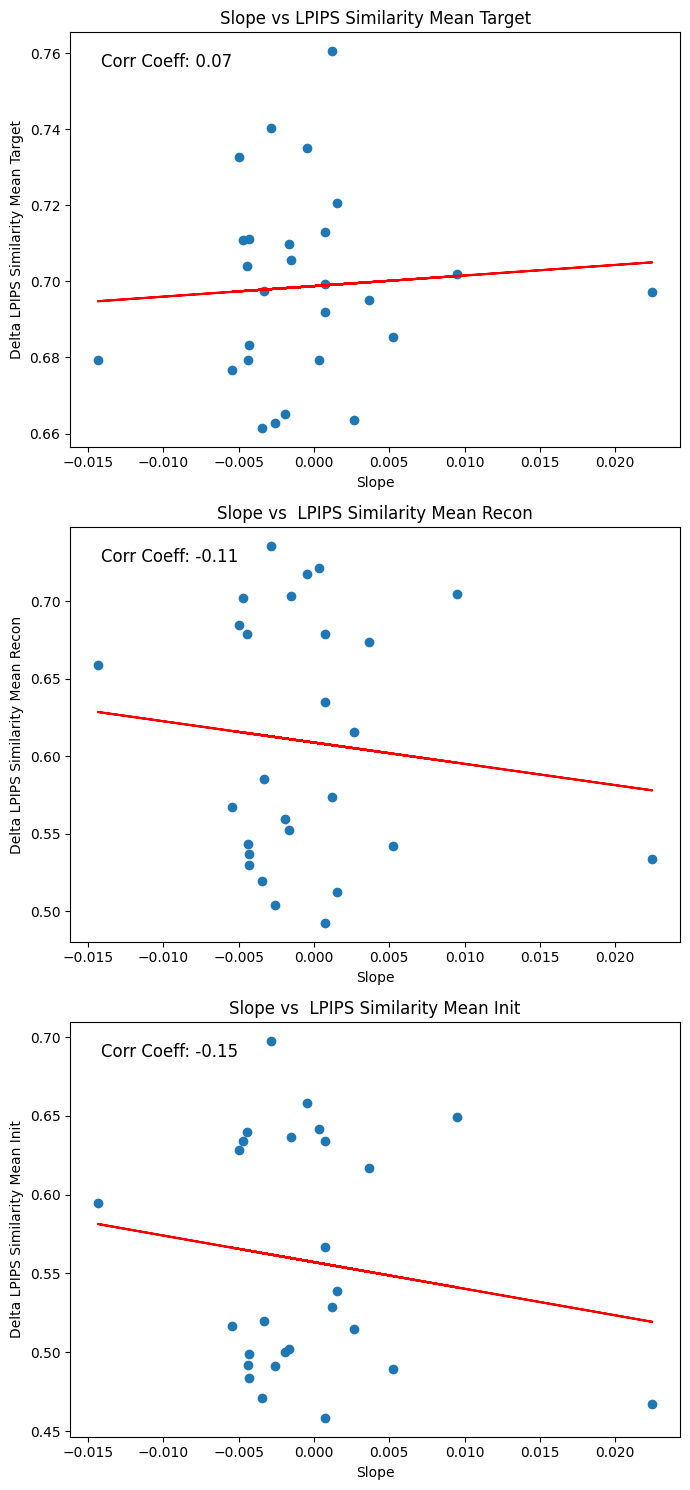

In [35]:
import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots(3, 1, figsize=(7, 15))

# Helper function to clean data by removing NaNs
def clean_data(x, y):
    valid_indices = ~np.isnan(x) & ~np.isnan(y)
    return x[valid_indices], y[valid_indices]

# First subplot
x1 = slope_vec_masked
y1 = delta_resp_each_gen_masked_df['lpips_similarity_mean_target'].values  # Ensure it's a numpy array
x1_clean, y1_clean = clean_data(x1, y1)  # Clean data to remove NaNs

# Scatter plot
ax[0].scatter(x1_clean, y1_clean)
ax[0].set_title('Slope vs LPIPS Similarity Mean Target')
ax[0].set_xlabel('Slope')
ax[0].set_ylabel('Delta LPIPS Similarity Mean Target')

# Line of best fit
m1, b1 = np.polyfit(x1_clean, y1_clean, 1)
ax[0].plot(x1_clean, m1*x1_clean + b1, color='red')  # Add line of best fit

# Calculate the correlation coefficient
corr_coeff1 = np.corrcoef(x1_clean, y1_clean)[0, 1]
ax[0].text(0.05, 0.95, f'Corr Coeff: {corr_coeff1:.2f}', transform=ax[0].transAxes, fontsize=12, verticalalignment='top')

# Second subplot
x2 = slope_vec_masked
y2 = delta_resp_each_gen_masked_df['lpips_similarity_mean_recon'].values  # Ensure it's a numpy array
x2_clean, y2_clean = clean_data(x2, y2)  # Clean data to remove NaNs

# Scatter plot
ax[1].scatter(x2_clean, y2_clean)
ax[1].set_title('Slope vs  LPIPS Similarity Mean Recon')
ax[1].set_xlabel('Slope')
ax[1].set_ylabel('Delta LPIPS Similarity Mean Recon')

# Line of best fit
m2, b2 = np.polyfit(x2_clean, y2_clean, 1)
ax[1].plot(x2_clean, m2*x2_clean + b2, color='red')  # Add line of best fit

# Calculate the correlation coefficient
corr_coeff2 = np.corrcoef(x2_clean, y2_clean)[0, 1]
ax[1].text(0.05, 0.95, f'Corr Coeff: {corr_coeff2:.2f}', transform=ax[1].transAxes, fontsize=12, verticalalignment='top')
# Second subplot
x3 = slope_vec_masked
y3 = delta_resp_each_gen_masked_df['lpips_similarity_mean_init'].values  # Ensure it's a numpy array
x3_clean, y3_clean = clean_data(x3, y3)  # Clean data to remove NaNs

# Scatter plot
ax[2].scatter(x3_clean, y3_clean)
ax[2].set_title('Slope vs  LPIPS Similarity Mean Init')
ax[2].set_xlabel('Slope')
ax[2].set_ylabel('Delta LPIPS Similarity Mean Init')

# Line of best fit
m3, b3 = np.polyfit(x3_clean, y3_clean, 1)
ax[2].plot(x3_clean, m3*x3_clean + b3, color='red')  # Add line of best fit

# Calculate the correlation coefficient
corr_coeff3 = np.corrcoef(x3_clean, y3_clean)[0, 1]
ax[2].text(0.05, 0.95, f'Corr Coeff: {corr_coeff3:.2f}',
              transform=ax[2].transAxes, fontsize=12, verticalalignment='top')

plt.tight_layout()
plt.show()



In [ ]:
# lest plot the colloration between the lpips_similarity_mean_target and lpips_similarity_mean_recon
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.scatter(delta_resp_each_gen_masked_df['lpips_similarity_mean_target'], 
              delta_resp_each_gen_masked_df['lpips_similarity_mean_recon'], 
              c='g', label='recon_img vs target_img')

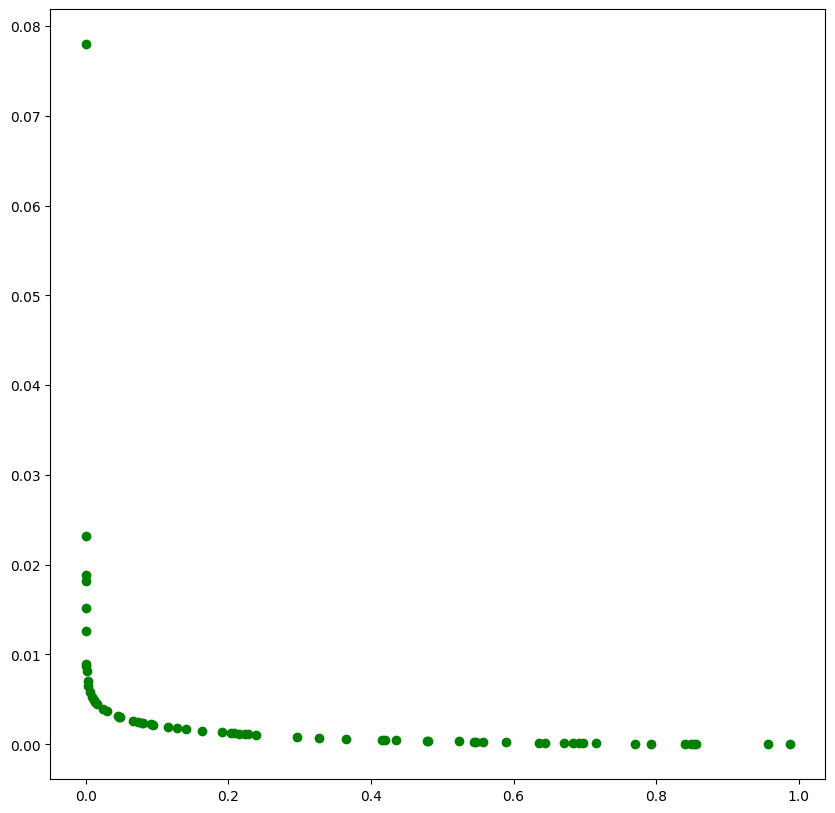

In [36]:
# plot p_value_masked vs r2_masked
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.scatter(delta_resp_each_gen_masked_df['pValue_vec_masked'], 
              delta_resp_each_gen_masked_df['r2_vec_masked'], 
              c='g', label='pValue vs r2')

In [ ]:
# LET PLOT THE SIMILARITY MAP FOR ALL
for i in range(len(similarity_map)):
    plt.figure()
    plt.imshow(similarity_map_img[i])
    plt.title(f"Similarity Map for Proto Image {i}")
    plt.colorbar()
    plt.show()

In [ ]:
similarity_map_img[i].shape

In [ ]:
# get proto target lpips similarity
#the file name is in this formai [exp_name]_[exp_idXXX].mat for example like Caos-12072023-007_expId056.mat
# let load an example file with it exp_id
recon_exp_id = 18

# let's load the file
exp_file = [f for f in recon_exp_files if f.endswith(f"expId{recon_exp_id:03d}.mat")][0]
# load the file
recon_exp_data = mat73.loadmat(os.path.join(recon_exp_path, exp_file))
iThread = 0
target_img = recon_exp_data['target_imgs_cell'][iThread]
img_size = recon_exp_data['img_size'][iThread]
img_poss = recon_exp_data['img_poss'][iThread]


# the proto file neame example is this: Caos-01082024-007_thread1_expId010_chan64_unit1.mat which formated as [exp_name]_thread[ithread]_expId[XXX]_chan[XX]_unit[X].mat
for proto_exp_id in range(len(proto_exp_files)):
    # use the extract_info function to extract the information from the filename
    proto_file = [f for f in proto_exp_files if f.count(f"expId{proto_exp_id+1:03d}")][0]
    proto_exp_data = mat73.loadmat(os.path.join(proto_exp_path, proto_file))
    proto_exp_info = extract_info_proto_exp(proto_file)
    exp_name_common = '-'.join(proto_exp_info['exp_name'].split('-')[0:2])
    chan_id = proto_exp_info['chan']
    unit_id = proto_exp_info['unit']


    # the scram exp data file name is formated like this [exp_name]_exp_idXXX_chanXX_unitX.mat for example like Caos-30112023-008_expId022_chan71_unit2
    # let's load the coresponded scram exp data which should be [exp_name_common]-*_chan[chan_id]_unit[unit_id].mat
    scram_exp_file = [f for f in scram_exp_files if (f.count(f"chan{chan_id:02d}") and f.count(f"unit{unit_id}") and f.count(exp_name_common))]
    # continue if the file is not found
    if len(scram_exp_file) == 0:
        continue
    scram_exp_file = scram_exp_file[0]
    scram_exp_info = mat73.loadmat(os.path.join(scram_exp_path, scram_exp_file))
    proto_size = scram_exp_info['img_size']
    proto_pos = scram_exp_info['img_pos']

    proto_img = proto_exp_data['top_mean_img_selected']
    proto_mask = scram_exp_info['overlapped_mask_exp']


    pixels_per_deg = 128

    # let's resize the target image 
    target_img_resized = cv2.resize(target_img, (int(img_size * pixels_per_deg), int(img_size * pixels_per_deg)))
    proto_img_real_pos = get_real_pos_img_unit8(proto_img, proto_pos, proto_size, screen_size=img_size,
                                                grayness_level=0.5, pixels_per_deg=pixels_per_deg)
    proto_img_real_mask = get_real_pos_img_unit8(proto_mask, proto_pos, proto_size, screen_size=img_size,
                                                pixels_per_deg=pixels_per_deg)
    similarity_map, similarity_map_img = compute_lpips_similarity(target_img_resized, proto_img_real_pos, net_type='alex')

    fig, ax = plt.subplots(1, 5, figsize=(15, 5))
    ax[0].imshow(target_img_resized)
    ax[0].set_title('Target Image')
    ax[1].imshow(apply_mask_to_image_uint8(proto_img_real_pos, proto_img_real_mask))
    ax[1].set_title('Proto Image')
    ax[2].imshow(similarity_map_img)
    ax[2].set_title('Similarity Map')
    # make 0 1 mask out of the proto_img_real_mask (> mean + 1*std)
    proto_img_real_mask_bin = proto_img_real_mask > np.mean(proto_img_real_mask) + 1*np.std(proto_img_real_mask)
    ax[3].imshow(similarity_map_img*proto_img_real_mask_bin)
    ax[3].set_title('Similarity Map Masked')

    proto_img_real_pos_torch = get_real_pos_img_torch(uint8_image_to_pytorch(proto_img), proto_pos, proto_size, screen_size=img_size,
                                                grayness_level=0.5, pixels_per_deg=pixels_per_deg)
    proto_img_real_mask_torch = get_real_pos_img_torch(torch.from_numpy(proto_mask), proto_pos, proto_size, screen_size=img_size,
                                                pixels_per_deg=pixels_per_deg)
    ax[4].imshow(np.transpose(apply_mask_to_image_torch(proto_img_real_pos_torch, proto_img_real_mask_torch).numpy(), (1, 2, 0)))
    # draw now
    plt.show()


#.....

#get_on_imaginary_screen(img, center_pos_deg, img_size_deg, screen_size=3, grayness_level=0.5, pixels_per_deg=128):

In [ ]:
def get_real_pos_img_unit8(img, center_pos_deg, img_size_deg, screen_size=3, grayness_level=0.5, pixels_per_deg=128):
    """
    Places an image on an imaginary screen with specified parameters.

    Parameters:
    - img: Input image as a NumPy array.
    - center_pos_deg: Tuple or list with 2 elements indicating the center position of the image in degrees.
    - img_size_deg: Size of the image in degrees.
    - screen_size: Size of the screen in degrees. Default is 3.
    - grayness_level: Grayness level of the screen, between 0 and 1. Default is 0.5.
    - pixels_per_deg: Number of pixels per degree. Default is 128.

    Returns:
    - A NumPy array representing the output image with the input image placed on the gray screen.
    """

    # Constants
    screen_size_pixels = int(screen_size * pixels_per_deg)

    # Create a gray background screen
    # make image if the input image! (i.e., 3D)
    if len(img.shape) == 3:
        out_img = np.uint8(255 * grayness_level * np.ones((screen_size_pixels, screen_size_pixels, 3)))
    elif len(img.shape) == 2:
        out_img = np.zeros((screen_size_pixels, screen_size_pixels))
    else:
        raise ValueError("Input image must be either 2D (grayscale) or 3D (RGB).")

    # Calculate the image size in pixels
    img_size_pixels = int(img_size_deg * pixels_per_deg)
    center_pos_deg_rev = [-center_pos_deg[1], center_pos_deg[0]]
    
    # Calculate the top-left corner of the image based on the center position
    center_pos_pixels = np.array(center_pos_deg_rev) * pixels_per_deg + np.array([screen_size_pixels / 2, screen_size_pixels / 2])
    top_left_corner = np.round(center_pos_pixels - img_size_pixels / 2).astype(int)
    
    # Resize the input image to the specified size in pixels
    resized_img = cv2.resize(img, (img_size_pixels, img_size_pixels))

    # Determine the cropping bounds
    crop_row_start, crop_col_start = max(1, -top_left_corner[0] + 1), max(1, -top_left_corner[1] + 1)
    crop_row_end, crop_col_end = min(img_size_pixels, screen_size_pixels - top_left_corner[0]), min(img_size_pixels, screen_size_pixels - top_left_corner[1])

    # Crop the image if it goes outside the screen
    if len(img.shape) == 3:
        cropped_img = resized_img[crop_row_start-1:crop_row_end, crop_col_start-1:crop_col_end, :]
    elif len(img.shape) == 2:
        cropped_img = resized_img[crop_row_start-1:crop_row_end, crop_col_start-1:crop_col_end]

    # Update the top-left corner for placing the cropped image
    top_left_corner = np.maximum(top_left_corner, [1, 1])
    bottom_right_corner = np.minimum(top_left_corner + np.array(cropped_img.shape[:2]) - 1, [screen_size_pixels, screen_size_pixels])

    # Place the cropped/resized image on the gray screen
    if len(img.shape) == 3:
        out_img[top_left_corner[0]-1:bottom_right_corner[0], top_left_corner[1]-1:bottom_right_corner[1], :] = cropped_img
    elif len(img.shape) == 2:
        out_img[top_left_corner[0]-1:bottom_right_corner[0], top_left_corner[1]-1:bottom_right_corner[1]] = cropped_img

    return out_img


import torchvision.transforms.functional as F

def get_real_pos_img_torch(img, center_pos_deg, img_size_deg, screen_size=3, grayness_level=0.5, pixels_per_deg=128):
    """
    Places an image on an imaginary screen with specified parameters, using PyTorch tensors.

    Parameters:
    - img (torch.Tensor): Input image as a PyTorch tensor of shape (C, H, W) or (1, H, W) for grayscale.
    - center_pos_deg (tuple or list): Center position of the image in degrees.
    - img_size_deg (float): Size of the image in degrees.
    - screen_size (float): Size of the screen in degrees. Default is 3.
    - grayness_level (float): Grayness level of the screen, between 0 and 1. Default is 0.5.
    - pixels_per_deg (int): Number of pixels per degree. Default is 128.

    Returns:
    - torch.Tensor: Output image with the input image placed on the gray screen.
    """

    # Constants
    screen_size_pixels = int(screen_size * pixels_per_deg)
    img_size_pixels = int(img_size_deg * pixels_per_deg)

    # Create a gray background screen
    if img.dim() == 3:
        out_img =  grayness_level * torch.ones((3, screen_size_pixels, screen_size_pixels))
    elif img.dim() == 2:
        out_img = grayness_level * torch.ones((1, screen_size_pixels, screen_size_pixels))
        img = img.unsqueeze(0)
    else:
        raise ValueError("Input image tensor must be 2D (1, H, W) for grayscale or 3D (C, H, W) for RGB.")

    center_pos_deg_rev = [-center_pos_deg[1], center_pos_deg[0]]
    
    # Calculate the top-left corner of the image based on the center position
    center_pos_pixels = np.array(center_pos_deg_rev) * pixels_per_deg + np.array([screen_size_pixels / 2, screen_size_pixels / 2])
    top_left_corner = np.round(center_pos_pixels - img_size_pixels / 2).astype(int)
    
    # Resize the input image to the specified size in pixels
    resized_img = F.resize(img, [img_size_pixels, img_size_pixels])

    # Determine the cropping bounds
    crop_row_start, crop_col_start = max(1, -top_left_corner[0] + 1), max(1, -top_left_corner[1] + 1)
    crop_row_end, crop_col_end = min(img_size_pixels, screen_size_pixels - top_left_corner[0]), min(img_size_pixels, screen_size_pixels - top_left_corner[1])

    # Crop the image if it goes outside the screen
    cropped_img = resized_img[:, crop_row_start-1:crop_row_end, crop_col_start-1:crop_col_end]

    # Update the top-left corner for placing the cropped image
    top_left_corner = np.maximum(top_left_corner, [1, 1])
    bottom_right_corner = np.minimum(top_left_corner + np.array(cropped_img.shape[1:]) - 1, [screen_size_pixels, screen_size_pixels])

    # Place the cropped/resized image on the gray screen
    out_img[:, top_left_corner[0]-1:bottom_right_corner[0], top_left_corner[1]-1:bottom_right_corner[1]] = cropped_img

    return out_img.squeeze()




In [ ]:
    '''''
    fig, ax = plt.subplots(1, 4, figsize=(15, 5))
    ax[0].imshow(target_img_resized)
    ax[0].set_title('Target Image')
    ax[1].imshow(apply_mask_to_image(proto_img_real_pos, proto_img_real_mask))
    ax[1].set_title('Proto Image')
    ax[2].imshow(similarity_map_img)
    ax[2].set_title('Similarity Map')
    # make 0 1 mask out of the proto_img_real_mask (> mean + 1*std)
    proto_img_real_mask_bin = proto_img_real_mask > np.mean(proto_img_real_mask) + 1*np.std(proto_img_real_mask)
    ax[3].imshow(similarity_map_img*proto_img_real_mask_bin)
    ax[3].set_title('Similarity Map Masked')

    # draw now
    plt.show()
    ''''


In [ ]:
# let loop over the recon exp data and compute the lpips similarity

pixels_per_deg = 128
for recon_exp_id in range(len(recon_exp_files)):
    # let's load the file
    exp_file = [f for f in recon_exp_files if f.endswith(f"expId{recon_exp_id+1:03d}.mat")][0]
    # load the file
    recon_exp_data = mat73.loadmat(os.path.join(recon_exp_path, exp_file))
    
    for iThread in range(int(recon_exp_data['num_of_thread'].item())):
        target_img = recon_exp_data['target_imgs_cell'][iThread]
        recon_img = recon_exp_data['recon_imgs_cell'][iThread]
        img_size = recon_exp_data['img_size'][iThread]
        img_poss = recon_exp_data['img_poss'][iThread]
        # let's resize the target image 
        target_img_resized = cv2.resize(target_img, (int(img_size * pixels_per_deg), int(img_size * pixels_per_deg)))
        
        proto_img_real_pos = get_real_pos_img(proto_img, proto_pos, proto_size, screen_size=img_size,
                                                    grayness_level=0.5, pixels_per_deg=pixels_per_deg)
        proto_img_real_mask = get_real_pos_img(proto_mask, proto_pos, proto_size, screen_size=img_size,
                                                    pixels_per_deg=pixels_per_deg)
        similarity_map, similarity_map_img = compute_lpips_similarity(target_img_resized, proto_img_real_pos, net_type='alex')
